# Model Fitting: ESS (Elliptical Slice Sampling)

In [72]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats as norm
import pandas as pd
import pymc as pm

import re
import numpy as np
import pickle as pickle

In [73]:
player_info = pd.read_csv("clean-data/player_info_pergame.csv")
game_outcomes = pd.read_csv("clean-data/game_outcomes_15-16.csv")

In [74]:
N_players = len(player_info)
N_teams = np.max(game_outcomes['Visitor_Index'].values) + 1
N_games =  len(game_outcomes)

print N_players, N_teams, N_games

476 30 1230


In [91]:
# print np.max(game_outcomes['Visitor_Index'].values)
# print np.max(game_outcomes['Home_Index'].values)

a = np.array([[1,2,3,4], [1,2,3,4]])
print a.shape
print a.mean(1)
print a[0][0:]

(2L, 4L)
[ 2.5  2.5]
[1 2 3 4]


In [76]:
player_info.head()

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Kobe Bryant,Los Angeles Lakers,25000000,SF,37,66,66,28.2,6.0,16.9,...,0.826,0.6,3.1,3.7,2.8,0.9,0.2,2.0,1.7,17.6
1,Joe Johnson,Brooklyn Nets,24894863,SF,34,81,81,33.4,4.7,10.6,...,0.831,0.6,3.0,3.6,3.9,0.8,0.0,2.0,1.8,12.2
2,LeBron James,Cleveland Cavaliers,22971000,SF,31,76,76,35.6,9.7,18.6,...,0.731,1.5,6.0,7.4,6.8,1.4,0.6,3.3,1.9,25.3
3,Carmelo Anthony,New York Knicks,22875000,SF,31,72,72,35.1,7.9,18.2,...,0.829,1.4,6.4,7.7,4.2,0.9,0.5,2.4,2.5,21.8
4,Dwight Howard,Houston Rockets,22359364,C,30,71,71,32.1,5.2,8.5,...,0.489,3.4,8.4,11.8,1.4,1.0,1.6,2.3,3.1,13.7


In [77]:
game_outcomes.head()

,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Year,diff,Visitor_Index,Home_Index
0,Detroit Pistons,106,Atlanta Hawks,94,2016,12,5,26
1,Cleveland Cavaliers,95,Chicago Bulls,97,2016,-2,25,11
2,New Orleans Pelicans,95,Golden State Warriors,111,2016,-16,24,10
3,Philadelphia 76ers,95,Boston Celtics,112,2016,-17,4,6
4,Chicago Bulls,115,Brooklyn Nets,100,2016,15,11,27


In [78]:
# player_info[guest_team_line_up[0]]
# player_info[host_team_line_up[0]]
# player_info['ORtg'].values
# player_info['Tm'].values[0]
# print game_outcomes['Visitor_Index'].values[0]


In [79]:
################# INPUT SECTION ###################
###################################################

########## player indicator for each game ######### (1230 x 476)
with open("clean-data/host_team_line_up.pkl", "rb") as f:
    host_team_line_up = pickle.load(f)

with open("clean-data/guest_team_line_up.pkl", "rb") as f:
    guest_team_line_up = pickle.load(f)
    
# print len(host_team_line_up[0])
host_lineup_arr = np.array(host_team_line_up)
guest_lineup_arr = np.array(guest_team_line_up)


######### team indicator for each game ########### (1230 x 30)
guest_matrix = np.zeros((game_outcomes.shape[0], np.max(game_outcomes['Visitor_Index']) + 1), dtype = bool)
guest_matrix.shape
host_matrix = np.copy(guest_matrix)

def make_matrix(mat, indices):
    for (i, ind) in enumerate(indices):
        mat[i, ind] = True

make_matrix(host_matrix, game_outcomes['Visitor_Index'].values)
make_matrix(guest_matrix, game_outcomes['Home_Index'].values)
# print host_matrix.shape


############## Observed data ##################
score_diff = game_outcomes['diff'].values
off_rating = player_info['PTS'].values + player_info['AST'].values
def_rating = player_info['BLK'].values + player_info["STL"].values + player_info['DRB'].values

In [94]:
def split_params(coefs, nplayers, nteams):
    '''
    Split the parameters
    first are the beta0 for each team
    then the beta for each player
    then the gamma0 for each team
    then the gamma for each player'''
    assert(coefs.shape == (2*(nplayers+nteams),))
    
    beta0 = coefs[:nteams]
    beta_player = coefs[nteams:(nplayers + nteams)]
    gamma0 = coefs[(nplayers + nteams):(nplayers + 2*nteams)]
    gamma_player = coefs[(nplayers + 2*nteams):]
    
    # parameterize sigma by its log
#     logsigma = coefs[-1]
    
    assert(beta0.shape == (nteams,))
    assert(beta_player.shape == (nplayers,))
    assert(beta0.shape == (nteams,))
    assert(gamma_player.shape == (nplayers,))
    
    return (beta0, beta_player, gamma0, gamma_player)

def logLik(coefs, lam = 1, sigma = 15.):
    ''' evaluate the negative log likelihood for our basketball model '''
    
    beta0, betas, gamma0, gammas = \
            split_params(coefs, nplayers, nteams)
    
    nteams = len(beta0)
    players = len(betas)
    ngames = game_diff.shape[0]
    
    guest_off_0 = np.dot(guest_matrix, beta0)
    guest_def_0 = np.dot(guest_matrix, gamma0)
    host_off_0 = np.dot(host_matrix, beta0)
    host_def_0 = np.dot(host_matrix, gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr, betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr, gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr, betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr, gammas * def_rating)
    
    mean = guest_off - host_def - (host_off - guest_def)
    
    loglik = np.sum(norm.logpdf(game_diff, mean, sigma))
    
    # add L2 regularization
    loglik -= lam * np.dot(coefs, coefs)
    return(loglik)

def changeCoefs(coefs, theta, norm_random):
    ''' evaluate the negative log likelihood for our basketball model '''
    
    beta0, betas, gamma0, gammas = \
            split_params(coefs, nplayers, nteams)    
    
    nomr_beta0, norm_betas, norm_gamma0, norm_gammas = \
            split_params(norm_random, nplayers, nteams)
    
    nteams = len(beta0)
    nplayers = len(betas)
    
    new_coefs = np.zeros((coefs.shape[0], coefs.shape[1]))
    new_coefs[:teams] = new_beta0
    
    new_coefs[:nteams] = beta0 * np.cos(theta) + norm_beta0 * np.sin(theta)
    new_coefs[nteams:(nplayers + nteams)] = gamma0 * np.cos(theta) + norm_gamma0 * np.sin(theta)
    new_coefs[(nplayers + nteams):(nplayers + 2*nteams)] = betas * np.cos(theta) + norm_betas * np.sin(theta)
    new_coefs[(nplayers + 2*nteams):] = gammas * np.cos(theta) + norm_gammas * np.sin(theta)
    
    return new_coefs

In [95]:
nplayers = player_info.shape[0]
nteams = host_matrix.shape[1]
# nteams = N_teams

coefs = np.random.randn(2*(nplayers + nteams))
b0, bs, g0, gs = split_params(coefs, nplayers, nteams)

host_lineup_arr = np.array(host_team_line_up)
guest_lineup_arr = np.array(guest_team_line_up)

In [96]:
# a = np.random.rand(5)
# temp = np.zeros((5,5))
# temp[0,:] = a
# print a
# print temp

# mvn = np.random.multivariate_normal

# print mvn(np.zeros(3), np.identity(3), 5)

In [97]:
mvn = np.random.multivariate_normal
def ess(logLik, N_mcmc, burn_in):
    bi = burn_in
#     N_1 = len(player_info[guest_team_line_up[game_index]]) + 1
#     N_2 = len(player_info[host_team_line_up[game_index]]) + 1
    
    nplayers = player_info.shape[0]
    nteams = host_matrix.shape[1]

    init_coefs = np.random.randn(2*(nplayers + nteams))
    b0, bs, g0, gs = split_params(init_coefs, nplayers, nteams)

    host_lineup_arr = np.array(host_team_line_up)
    guest_lineup_arr = np.array(guest_team_line_up)
    
    temp_coefs = np.zeros((N_mcmc + burn_in, 2*(nplayers + nteams)))
    ## initialization
    temp_coefs[0,:] = init_coefs
    
#     negloglik(coefs, game_diff, off_rating, def_rating, nplayers, nteams,
#        guest_matrix, host_matrix, guest_lineup_arr, host_lineup_arr)
    
    
    # INITIALIZATION
    # the latent variable states
    # first two correspond to the weight factors for the players
#     states_player_g = np.zeros((N_mcmc + burn_in, N_players))
#     states_player_h = np.zeros((N_mcmc + burn_in, N_players))
    
    # the below is the constant value factors for the teams (when they're host and guest)
#     states_team_g = np.zeros((N_mcmc + burn_in, N_teams))
#     states_team_h = np.zeros((N_mcmc + burn_in, N_teams))
        
    # random draw from normal distribution with which we'll determine
    # new state of the latent variables
#     norm_player_g = mvn(np.zeros(N_players), np.identity(N_players), N_mcmc + bi)
#     norm_player_h = mvn(np.zeros(N_players), np.identity(N_players), N_mcmc + bi)
#     norm_team_g = mvn(np.zeros(N_teams), np.identity(N_teams), N_mcmc + bi)
#     norm_team_h = mvn(np.zeros(N_teams), np.identity(N_teams), N_mcmc + bi)
    
    dim = 2*(N_teams + N_players)
    norm_random = mvn(np.zeros(dim), np.identity(dim), N_mcmc+bi)
    
    # random draw from unifrom distribution with which we'll determine 
    # the loglikelihood threshold (likelihood threshold defines the 'slice' where we sample)
    unif_samples = np.random.uniform(0, 1, N_mcmc+bi)
    
    # initial proposal of the theta
    theta = np.random.uniform(0, 2*np.pi, N_mcmc+bi)
    
    # variables with which we'll propose a new state by shrinking the range of theta
    theta_min = theta - 2*np.pi
    theta_max = theta + 2*np.pi
    
    # We select a new location (i.e. new state of the latent variables)
    # on the randomly generated ellipse given theta and norm_samples
    for i in range(1, N_mcmc + bi):
#         if i % 100 == 0:
#             print i

        # initial state of the latent vairables    
#         f_g = bs[i - 1,:]
#         f_h = gs[i - 1,:]
#         f_team_g = b0[i - 1, :]
#         f_team_h = g0[i - 1, :]        
        coefs = temp_coefs[i - 1, :]

        # the loglikelihood threshold
        # the threshold is chosen between [0, Likelihood]
#         llh_thresh = log_likelihood(f_g, f_h, f_team_g, f_team_h) + np.log(unif_samples[i])
        llh_thresh = logLik(coefs) + np.log(unif_samples[i])
        
        # new proposals for the latent variable states
        new_coefs = changeCoefs(coefs, theta[i], norm_random[i,:])
#         f_prime_g = (f_g * np.cos(theta[i])) + (norm_player_g[i,:] * np.sin(theta[i]))
#         f_prime_h = (f_h * np.cos(theta[i])) + (norm_player_h[i,:] * np.sin(theta[i]))
#         f_prime_team_g = (f_team_g * np.cos(theta[i])) + (norm_team_g[i,:] * np.sin(theta[i]))
#         f_prime_team_h = (f_team_h * np.cos(theta[i])) + (norm_team_h[i,:] * np.sin(theta[i]))
        
        while logLik(new_coefs) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]

            # shrink the range of the search for the new proposal while we logLikelohood > threshold
            theta[i] = np.random.uniform(theta_min[i], theta_max[i], 1)  
            
            # new proposals with the changed range of the ellipse
            new_coefs = changeCoefs(coefs, theta[i], norm_random[i,:])
            
#             f_prime_g = (f_g * np.cos(theta[i])) + (norm_player_g[i,:] * np.sin(theta[i]))
#             f_prime_h = (f_h * np.cos(theta[i])) + (norm_player_h[i,:] * np.sin(theta[i]))
#             f_prime_team_g = (f_team_g * np.cos(theta[i])) + (norm_team_g[i,:] * np.sin(theta[i]))
#             f_prime_team_h = (f_team_h * np.cos(theta[i])) + (norm_team_h[i,:] * np.sin(theta[i]))
                
        
        # when the condition is satisfied, we keep the proposals of the latent variable states
        temp_coefs[i, :] = new_coefs
#         states_player_g[i,:] = f_prime_g
#         states_player_h[i,:] = f_prime_h
#         states_team_g[i, :] = f_prime_team_g
#         states_team_h[i, :] = f_prime_team_h
#         return states_player_g[(bi+1):(bi+N_mcmc),], states_player_h[(bi+1):(bi+N_mcmc),], states_team_g[(bi+1):(bi+N_mcmc),], states_team_h[(bi+1):(bi+N_mcmc),]
    # return except the burnin     
    return temp_coefs[(bi + 1): (bi + N_mcmc)]

In [84]:
# #elliptical slice sampler (Murray, Adams, and MacKay JMLR 2010)
# # Inputs:
# # Y: observed data
# # Sig: covariance matrix of the prior
# # log_lik: the log likelihood function
# # N_mcmc: number of desired samples
# # burn_in: number of burn in iterations
# # N: dimensionality of the input, this should be M+1 because alpha is part of Sigma

# # returns an array of samples of size N_mcmc x N

    
# def ess(Y, Sig,log_lik, N_mcmc, burn_in, N):
#     print 'running elliptical slice sampling...'
#     mcmc_samples = np.zeros((N_mcmc+burn_in, N))
#     norm_samples = np.random.multivariate_normal(np.zeros(N), Sig, N_mcmc+burn_in)
#     unif_samples = np.random.uniform(0,1,N_mcmc+burn_in)
#     theta = np.random.uniform(0,2*np.pi,N_mcmc+burn_in)
#     theta_min = theta-2*np.pi
#     theta_max = theta+2*np.pi
#     for i in range(1,N_mcmc+burn_in):
        
#         if i%100 == 0:
#             print i
#         f = mcmc_samples[i-1,:]
#         #print f, Y
#         llh_thresh = log_lik(f,Y) + np.log(unif_samples[i])
#         f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i])
#         while log_lik(f_star,Y) < llh_thresh:
#             if theta[i] < 0:
#                 theta_min[i] = theta[i]
#             else:
#                 theta_max[i] = theta[i]
#             theta[i] = np.random.uniform(theta_min[i],theta_max[i],1)  
#             f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i]) 		
#         mcmc_samples[i,:] = f_star
#     return mcmc_samples[(burn_in+1):(burn_in+N_mcmc),]

In [ ]:
# ortg_values = player_info['ORtg'].values
# drtg_values = player_info['DRtg'].values

# log likelihood for standard Gaussian
def log_likelihood(f_guest, f_host, f_team_g, f_team_h):
    # f_i is the state of the latent variables: the vector 'beta' for team2 and the vector 'gamma' for team2
    
    loglikelihood = 0.0
    for i in range(N_games):
        # indicators of the players for the host & guest in ith-game
        guest_i = guest_team_line_up[i]
        host_i = host_team_line_up[i]
        
        # indicators of the teams playing for th ith-game
        team_g_i = game_outcomes['Visitor_Index'].values[i]
        team_h_i = game_outcomes['Home_Index'].values[i]

        guest_diff = (f_team_g[team_g_i] + ortg_values[guest_i].dot(f_guest[guest_i])) - (f_team_h[team_h_i] + drtg_values[host_i].dot(f_host[host_i]))
        host_diff = (f_team_h[team_h_i] + ortg_values[host_i].dot(f_host[host_i])) - (f_team_g[team_g_i] + drtg_values[guest_i].dot(f_guest[guest_i]))
        new_mean = guest_diff - host_diff
        
        loglikelihood += scipy.stats.norm.logpdf(score_diff[i], new_mean, 1.0)    
    return loglikelihood

In [22]:
def diff_score_calc(game_i, f_guest, f_host, f_team_g, f_team_h):
    # indicators of the players for the host & guest in ith-game
    guest_i = guest_team_line_up[game_i]
    host_i = host_team_line_up[game_i]

    # indicators of the teams playing for th ith-game
    team_g_i = game_outcomes['Visitor_Index'].values[game_i]
    team_h_i = game_outcomes['Home_Index'].values[game_i]

#     print f_guest.shape, guest_i.shape
#     print f_host.shape, host_i.shape
#     print f_team_g, team_g_i
#     print f_team_h, team_h_i
    
    guest_diff = (f_team_g[team_g_i] + ortg_values[guest_i].dot(f_guest[guest_i])) - (f_team_h[team_h_i] + drtg_values[host_i].dot(f_host[host_i]))
    host_diff = (f_team_h[team_h_i] + ortg_values[host_i].dot(f_host[host_i])) - (f_team_g[team_g_i] + drtg_values[guest_i].dot(f_guest[guest_i]))
    
    return guest_diff - host_diff

In [12]:
# # log likelihood for standard Gaussian
# def log_likelihood(f_guest, f_host, f_team_g, f_team_h):
#     new_mean = diff_score_calc(f_guest, f_host, f_team_g, f_team_h)    
#     return scipy.stats.norm.logpdf(score_diff[game_index], new_mean, 1.0)

In [67]:
# mvn = np.random.multivariate_normal

# def ess(log_likelihood, N_mcmc, burn_in):
#     bi = burn_in
# #     N_1 = len(player_info[guest_team_line_up[game_index]]) + 1
# #     N_2 = len(player_info[host_team_line_up[game_index]]) + 1
    
#     # INITIALIZATION
#     # the latent variable states
#     # first two correspond to the weight factors for the players
#     states_player_g = np.zeros((N_mcmc + burn_in, N_players))
#     states_player_h = np.zeros((N_mcmc + burn_in, N_players))
    
#     # the below is the constant value factors for the teams (when they're host and guest)
#     states_team_g = np.zeros((N_mcmc + burn_in, N_teams))
#     states_team_h = np.zeros((N_mcmc + burn_in, N_teams))
        
#     # random draw from normal distribution with which we'll determine
#     # new state of the latent variables
#     norm_player_g = mvn(np.zeros(N_players), np.identity(N_players), N_mcmc + bi)
#     norm_player_h = mvn(np.zeros(N_players), np.identity(N_players), N_mcmc + bi)
#     norm_team_g = mvn(np.zeros(N_teams), np.identity(N_teams), N_mcmc + bi)
#     norm_team_h = mvn(np.zeros(N_teams), np.identity(N_teams), N_mcmc + bi)
    
#     # random draw from unifrom distribution with which we'll determine 
#     # the loglikelihood threshold (likelihood threshold defines the 'slice' where we sample)
#     unif_samples = np.random.uniform(0, 1, N_mcmc+bi)
    
#     # initial proposal of the theta
#     theta = np.random.uniform(0, 2*np.pi, N_mcmc+bi)
    
#     # variables with which we'll propose a new state by shrinking the range of theta
#     theta_min = theta - 2*np.pi
#     theta_max = theta + 2*np.pi
    
#     # We select a new location (i.e. new state of the latent variables)
#     # on the randomly generated ellipse given theta and norm_samples
#     for i in range(1, N_mcmc + bi):
# #         if i % 100 == 0:
# #             print i

#         # initial state of the latent vairables    
#         f_g = states_player_g[i - 1,:]
#         f_h = states_player_h[i - 1,:]
#         f_team_g = states_team_g[i - 1, :]
#         f_team_h = states_team_h[i - 1, :]

#         # the loglikelihood threshold
#         # the threshold is chosen between [0, Likelihood]
#         llh_thresh = log_likelihood(f_g, f_h, f_team_g, f_team_h) + np.log(unif_samples[i])
        
#         f_prime_g = (f_g * np.cos(theta[i])) + (norm_player_g[i,:] * np.sin(theta[i]))
#         f_prime_h = (f_h * np.cos(theta[i])) + (norm_player_h[i,:] * np.sin(theta[i]))
#         f_prime_team_g = (f_team_g * np.cos(theta[i])) + (norm_team_g[i,:] * np.sin(theta[i]))
#         f_prime_team_h = (f_team_h * np.cos(theta[i])) + (norm_team_h[i,:] * np.sin(theta[i]))
        
#         while log_likelihood(f_prime_g, f_prime_h, f_prime_team_g, f_prime_team_h) < llh_thresh:
#             if theta[i] < 0:
#                 theta_min[i] = theta[i]
#             else:
#                 theta_max[i] = theta[i]
                
#             theta[i] = np.random.uniform(theta_min[i], theta_max[i], 1)  
            
#             f_prime_g = (f_g * np.cos(theta[i])) + (norm_player_g[i,:] * np.sin(theta[i]))
#             f_prime_h = (f_h * np.cos(theta[i])) + (norm_player_h[i,:] * np.sin(theta[i]))
#             f_prime_team_g = (f_team_g * np.cos(theta[i])) + (norm_team_g[i,:] * np.sin(theta[i]))
#             f_prime_team_h = (f_team_h * np.cos(theta[i])) + (norm_team_h[i,:] * np.sin(theta[i]))
                
#         states_player_g[i,:] = f_prime_g
#         states_player_h[i,:] = f_prime_h
#         states_team_g[i, :] = f_prime_team_g
#         states_team_h[i, :] = f_prime_team_h
            
#     return states_player_g[(bi+1):(bi+N_mcmc),], states_player_h[(bi+1):(bi+N_mcmc),], states_team_g[(bi+1):(bi+N_mcmc),], states_team_h[(bi+1):(bi+N_mcmc),]

# Estimation of the latent variable states for Guest & Host in a certain game

In [98]:
# game_index = 10
N_mcmc = 200
burn_in = 0
stateCoefs = ess(logLik, N_mcmc, burn_in)
# print guest_states
# print guest_states.shape

mean_coefs = stateCoefs.mean(axis=0)
b0, bs, g0, gs = split_params(mean_coefs, N_players, N_teams)

print b0, bs, g0, gs
# mean_beta = beta.mean(axis=0)
# mean_gamma =  gamma.mean(axis=0)
# print mean_beta, mean_beta.shape
# print mean_gamma, mean_gamma.shape

# mean_beta0 = beta0.mean(axis=0)
# mean_gamma0 =  gamma0.mean(axis=0)
# print mean_beta0, mean_beta0.shape
# print mean_gamma0, mean_gamma0.shape

UnboundLocalError: local variable 'nteams' referenced before assignment

In [25]:
game_i = 10
real = score_diff[game_i]
estimated = diff_score_calc(game_i, mean_beta, mean_gamma, mean_beta0, mean_gamma0)
print 'the actual differential score = %s' %(real)
print 'the differential score with the estimated variable states = %s' %(estimated)
print 'difference is %s percent' %(np.fabs(real - estimated)*100.0/real)

the actual differential score = 25.0
the differential score with the estimated variable states = -6.23872627579
difference is 124.954905103 percent


# Rough convergence test through MAP estimation

The MAP value for beta 0 is: 0.336228882015
The MAP value for beta 1 is: -0.265242810672
The MAP value for beta 2 is: 0.463516721215
The MAP value for beta 3 is: -0.104109097249
The MAP value for beta 4 is: 0.899649231934
The MAP value for beta 5 is: 0.172382589724
The MAP value for beta 6 is: 0.976192366029
The MAP value for beta 7 is: 0.0910913165798
The MAP value for beta 8 is: 0.176747535163
The MAP value for beta 9 is: 0.0194308217499
The MAP value for beta 10 is: -0.188257255891
The MAP value for beta 11 is: 0.410625682971
The MAP value for beta 12 is: -0.0106572331228
The MAP value for beta 13 is: -0.412692411715
The MAP value for beta 14 is: 0.284226345251
The MAP value for beta 15 is: 0.222039327213


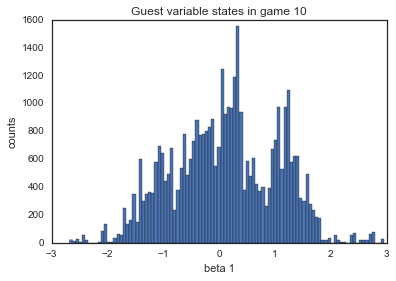

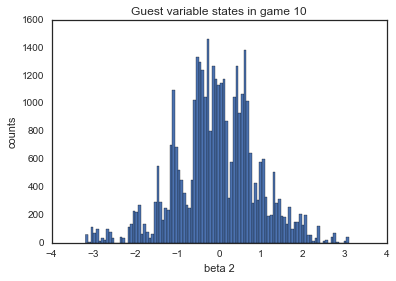

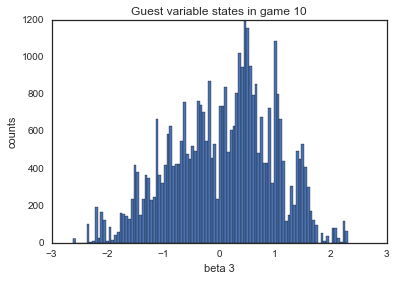

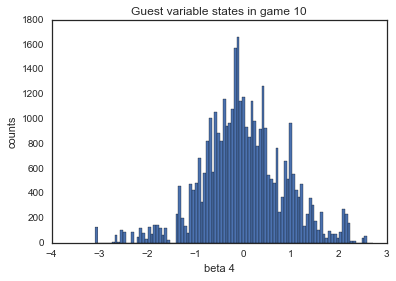

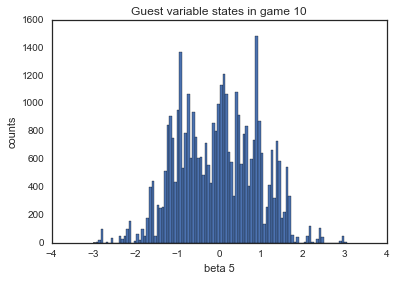

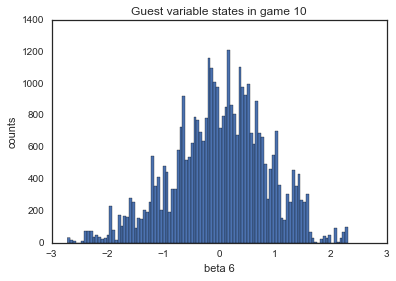

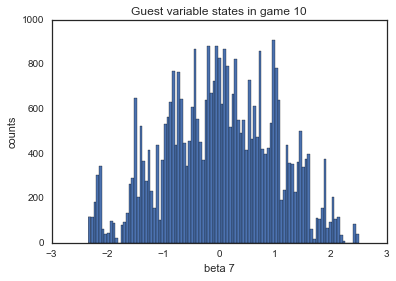

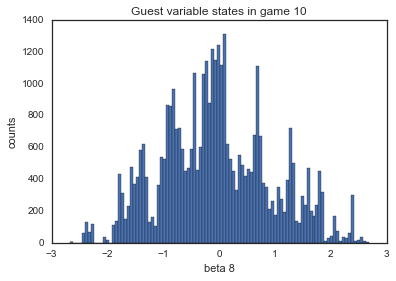

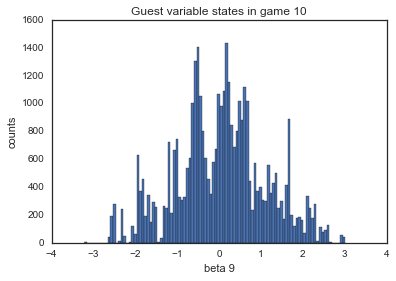

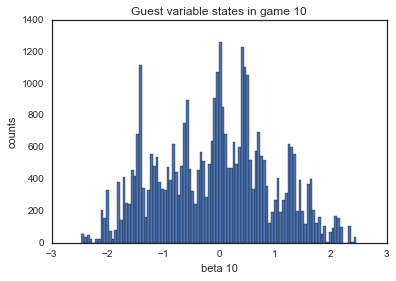

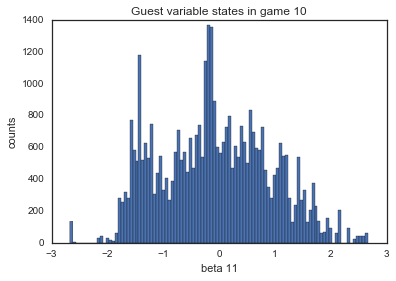

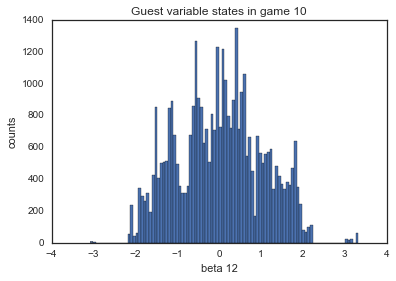

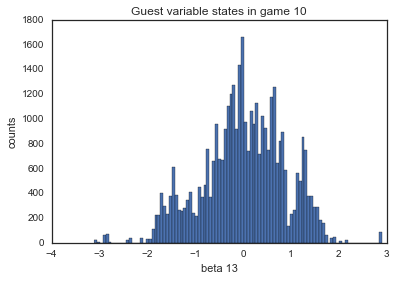

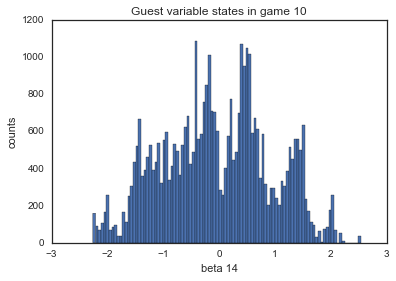

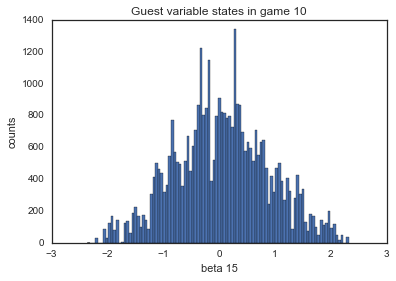

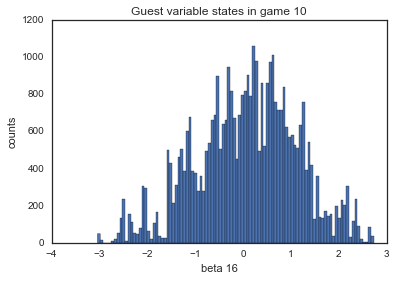

In [181]:
for i in range(guest_states.shape[1]):
    plt.figure(i)
    p_hist = plt.hist(guest_states[burn_in:,i], bins=100)
    plt.title("Guest variable states in game %s" %(game_index))
    plt.xlabel("beta %s" %(i+1))
    plt.ylabel("counts")
    p_map_index = np.argmax(p_hist[0])
    p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
    p_map = p_hist_bin_middle[p_map_index]
    
    print "The MAP value for beta %s is: %s" %(i, p_map)

The MAP value for beta 0 is: 0.132855714515
The MAP value for beta 1 is: -0.230545311054
The MAP value for beta 2 is: 0.012881243031
The MAP value for beta 3 is: 0.321966505191
The MAP value for beta 4 is: 0.0816277899036
The MAP value for beta 5 is: -0.105640398101
The MAP value for beta 6 is: -0.754148401615
The MAP value for beta 7 is: 0.354808272057
The MAP value for beta 8 is: -0.349944854498
The MAP value for beta 9 is: 0.344138735411
The MAP value for beta 10 is: -0.319858476601
The MAP value for beta 11 is: 0.470722184531
The MAP value for beta 12 is: 0.0265529017554
The MAP value for beta 13 is: 0.0410428002737
The MAP value for beta 14 is: 0.0733286720183


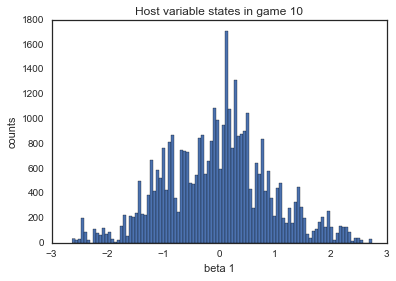

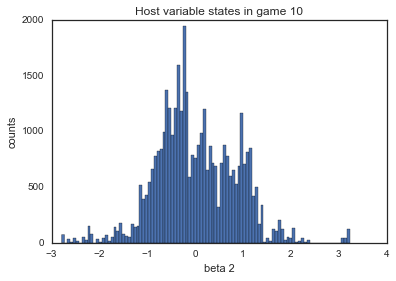

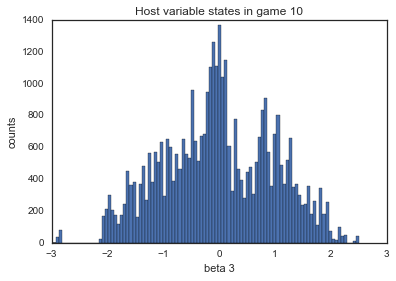

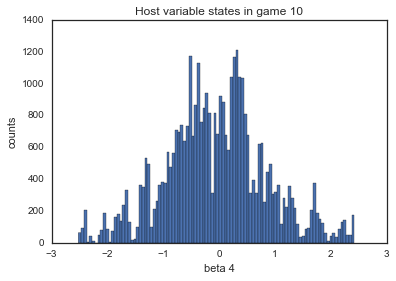

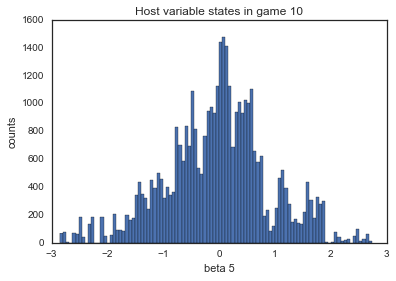

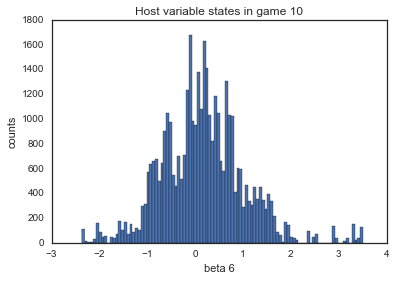

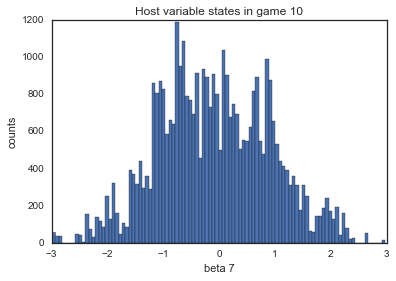

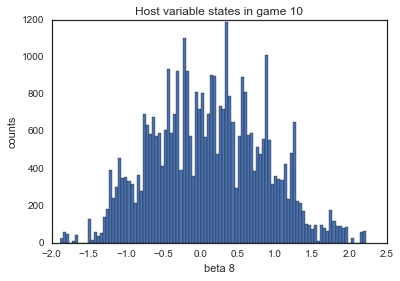

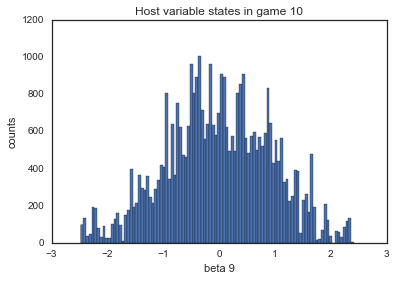

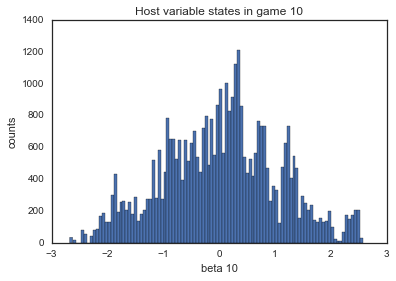

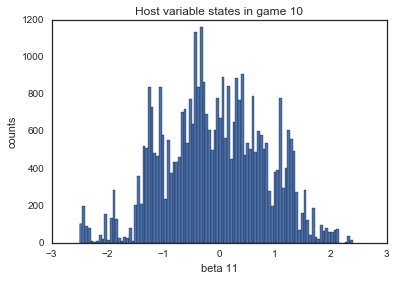

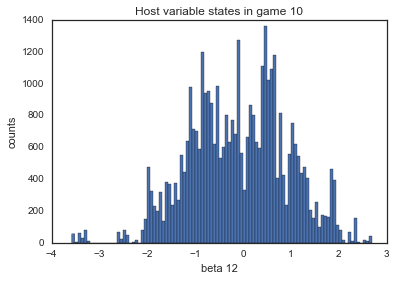

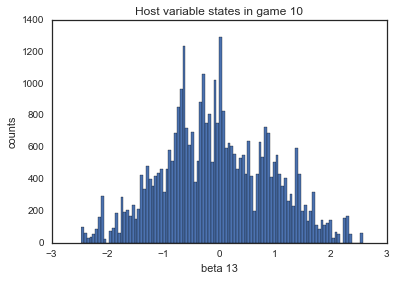

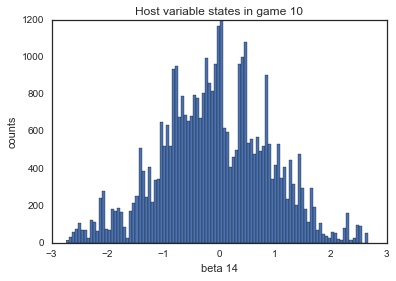

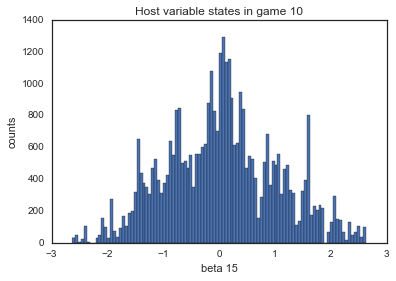

In [182]:
for i in range(host_states.shape[1]):
    plt.figure(i)
    p_hist = plt.hist(host_states[burn_in:,i], bins=100)
    plt.title("Host variable states in game %s" %(game_index))
    plt.xlabel("beta %s" %(i+1))
    plt.ylabel("counts")
    p_map_index = np.argmax(p_hist[0])
    p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
    p_map = p_hist_bin_middle[p_map_index]
    
    print "The MAP value for beta %s is: %s" %(i, p_map)

## Discussion:
# We need to discuss how we're going to deal with the results from multiple games for each team. Is it reasonable to just avearge them out?
# I think so; then, I can vactorize the above code in which I can input the entire game data rather than a single game data.
# However, there could be more sophisticated ideas to take the multiple game results into account?